# NBAS

In [ ]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.7.1


# NBAS
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for NBAS.

In [2]:
gene_symbol = 'NBAS'
mane_tx_id = 'NM_015909.4'
mane_protein_id = "NP_056993.2"

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.21'  # Update, if necessary
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals from {cohort}')
qc.summarize()

Individuals Processed: 100%|██████████| 67/67 [00:22<00:00,  2.92individuals/s]
Loaded 67 individuals from Cohort(members=(Patient(labels:case report[PMID_28611345_case_report], sex:Sex.FEMALE, age:Age(days=1461.0, timeline=Timeline.POSTNATAL), vital_status:VitalStatus(status=<Status.ALIVE: 1>, age_of_death=None), variants:(Variant(variant_info=VariantInfo(variant_coordinates=VariantCoordinates(region=GenomicRegion(contig=2, start=15415663, end=15415664, strand=+), ref=T, alt=G, change_length=0), sv_info=None), tx_annotations=(TranscriptAnnotation(gene_id:NBAS,transcript_id:NM_015909.4,hgvs_cdna:NM_015909.4:c.2819A>C,is_preferred:True,variant_effects:(<VariantEffect.MISSENSE_VARIANT: 'SO:0001583'>,),overlapping_exons:(25,),protein_id:NP_056993.2,hgvsp:NP_056993.2:p.His940Pro,protein_effect_location:Region(start=939, end=940)),), genotypes=Genotypes(['case report[PMID_28611345_case_report]=1/1'])),), phenotypes:[DefaultTermId(idx=2, value=HP_0031964), DefaultTermId(idx=2, value=HP_00319

In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Acute hepatic failure,HP:0006554,55
Short stature,HP:0004322,34
Elevated circulating aspartate aminotransferase concentration,HP:0031956,28
Elevated circulating alanine aminotransferase concentration,HP:0031964,27
Hyposegmentation of neutrophil nuclei,HP:0011447,20
Prolonged prothrombin time,HP:0008151,18
Hyperammonemia,HP:0001987,16
Decreased circulating IgG level,HP:0004315,16
Hepatomegaly,HP:0002240,15
Increased total bilirubin,HP:0003573,15


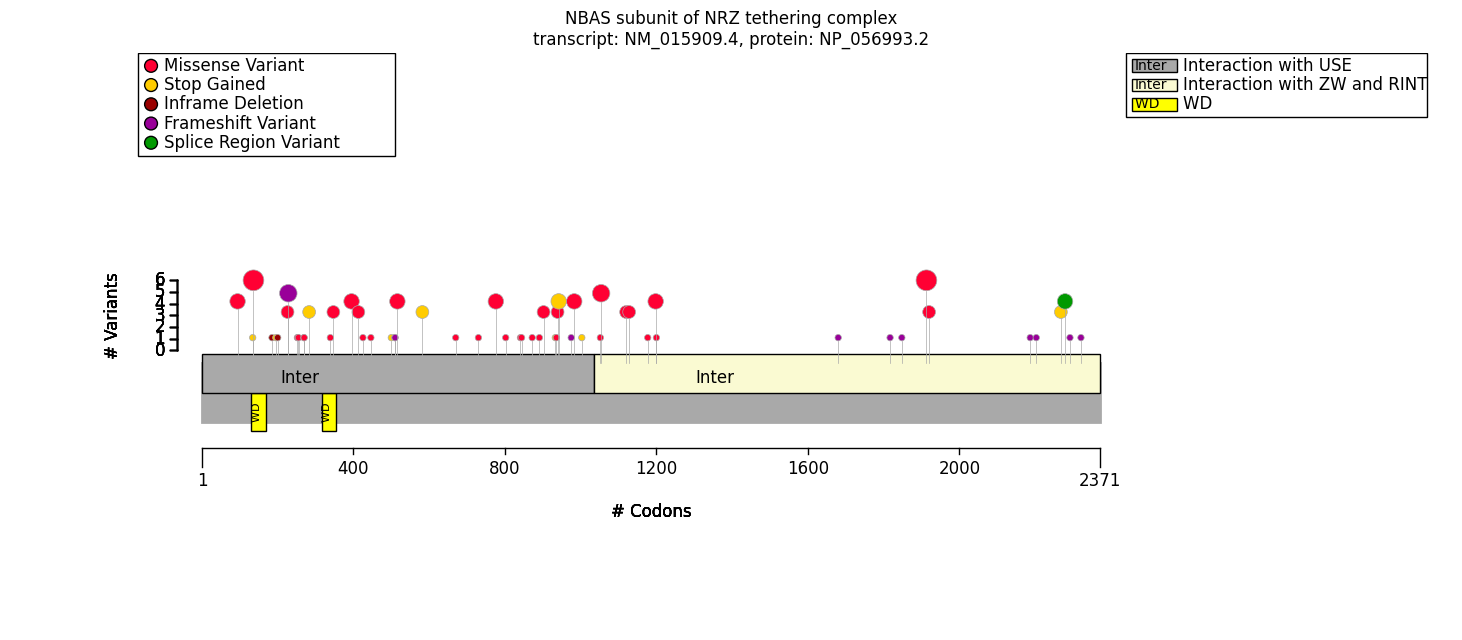

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService, configure_default_protein_metadata_service
import matplotlib.pyplot as plt
from gpsea.view import ProteinVisualizer

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id) 
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)



nbas_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
nbas_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Name,Type,Coordinates,Count,Variants
Interaction with USE1,REGION,1 - 1035,68,p.Leu271Pro; p.Pro937Ala; p.Gly254Asp; p.Leu202del; p.Pro777His; p.Glu447Lys; p.Cys426Trp; p.Ile984Ser; p.Trp396Ter; p.His940Pro; p.Ile187del; p.Arg137Trp; p.Cys256Tyr; p.Glu943Ter; p.Gly340Arg; p.Ile984LeufsTer8; p.Phe671Cys; p.Trp845Cys; p.Arg510Ter; p.Ser230GlnfsTer4; p.Trp396Arg; p.Arg517Cys; p.Val892Phe; p.Ser976ProfsTer16; p.Ser414Phe; p.Ile512ThrfsTer4; p.Arg517His; p.Lys284Ter; p.Trp583Ter; p.Pro348Ser; p.Trp934Ter; p.Thr731Pro; p.Arg1004Ter; p.Leu903Arg; p.Arg873Trp; p.Val842Phe; p.Ala95Val; p.Glu803Lys; p.Trp135Ter; p.Gly270Ala; p.His227Pro; p.Gln196Ter; p.Arg501Ter; p.Val253Gly
WD 1,REPEAT,130 - 169,7,p.Arg137Trp; p.Trp135Ter
WD 2,REPEAT,316 - 355,3,p.Pro348Ser; p.Gly340Arg
Interaction with ZW10 and RINT1,REGION,1036 - 2371,34,p.Leu1055Pro; p.Ser1129Phe; p.Gln2322HisfsTer18; p.Ala1921Pro; p.Arg1914Gly; p.Met2204IlefsTer3; p.Glu2269Ter; p.Trp1850GlyfsTer32; p.Thr2280=; p.Ser1178Arg; p.Ser1819LysfsTer16; p.Leu2293CysfsTer9; p.His1053Arg; p.Arg1914His; p.Ile1121Met; p.Gln1201Pro; p.Cys1199Tyr; p.Ser1681GlnfsTer37; p.Glu2189Ter


In [ ]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
2_15539327_15539327_G_A,c.409C>T,p.Arg137Trp,7,missense,6
SO:1000029_HGNC:15625_NBAS,SV involving NBAS,p.?,,chromosomal deletion,6
2_15238670_15238670_C_T,c.5741G>A,p.Arg1914His,45,missense,5
2_15394320_15394320_A_G,c.3164T>C,p.Leu1055Pro,28,missense,4
2_15534602_15534602_G_GA,c.686dup,p.Ser230GlnfsTer4,9,frameshift,4
2_15554064_15554064_G_A,c.284C>T,p.Ala95Val,4,missense,3
2_15415656_15415656_C_A,c.2827G>T,p.Glu943Ter,25,stop gained,3
2_15374715_15374715_C_T,c.3596G>A,p.Cys1199Tyr,31,missense,3
2_15461210_15461210_G_T,c.2330C>A,p.Pro777His,21,missense,3
2_15178988_15178988_C_T,c.6840G>A,p.Thr2280=,51,"splice region, synonymous",2


# Genotype Phenotype Correlation (GPC) Analysis

[Hammann et al. (2024)](https://pubmed.ncbi.nlm.nih.gov/38244286/) suggested that missense or in-frame deletions in the C-terminal region of the NBAS gene are associated with  [SOPH syndrome (614800)](https://omim.org/entry/608025), missense or in-frame deletions in the Sec30 domain of NBAS are associated with [infantile liver failure syndrome type 2](https://omim.org/entry/616483), and missense or in-frame deletions in the beta-propeller domain of NBAS are associated with a combined phenotype of multisystem involvement with acute liver failure.

We will therefore test these proposed associations as well as a potential correlation of missese variants.

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, biallelic_predicate


missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)


missense_predicate = biallelic_predicate(a_predicate=missense, 
                                   b_predicate=~missense, 
                                   a_label="missense",
                                   b_label="other",
                                   partitions=((0,),(2,1))
                                   )
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,28
HMF03,Skipping term because of a child term with the same individual counts,1
HMF08,Skipping general term,90
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,229


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense/missense          \
                                                               Count Percent   
Decreased circulating IgG level [HP:0004315]                    1/12      8%   
Hyposegmentation of neutrophil nuclei [HP:0011447]              3/16     19%   
Acute hepatic failure [HP:0006554]                             19/20     95%   
Delayed skeletal maturation [HP:0002750]                        3/11     27%   
Motor delay [HP:0001270]                                        3/11     27%   
Reduced bone mineral density [HP:0004349]                       5/14     36%   
Short stature [HP:0004322]                                      8/14     57%   
Elevated circulating alanine aminotransferase c...               4/4    100%   
Elevated hepatic transaminase [HP:0002910]                       9/9    100%   
Elevated circulating aspartate aminotransferase...               4/4    100%   
Hepatic failure [HP:0001399]                                   19/19    100%   
Growth delay [HP:0001510]                                        8/8    100%   

Allele group                                       other/other OR missense/other  \
                                                                           Count   
Decreased circulating IgG level [HP:0004315]                               15/23   
Hyposegmentation of neutrophil nuclei [HP:0011447]                         17/31   
Acute hepatic failure [HP:0006554]                                         36/43   
Delayed skeletal maturation [HP:0002750]                                    9/21   
Motor delay [HP:0001270]                                                    8/20   
Reduced bone mineral density [HP:0004349]                                   9/20   
Short stature [HP:0004322]                                                 26/40   
Elevated circulating alanine aminotransferase c...                         23/24   
Elevated hepatic transaminase [HP:0002910]                                 25/25   
Elevated circulating aspartate aminotransferase...                         24/25   
Hepatic failure [HP:0001399]                                               36/36   
Growth delay [HP:0001510]                                                  26/26   

Allele group                                                                   \
                                                   Percent Corrected p values   
Decreased circulating IgG level [HP:0004315]           65%           0.019335   
Hyposegmentation of neutrophil nuclei [HP:0011447]     55%           0.171827   
Acute hepatic failure [HP:0006554]                     84%           1.000000   
Delayed skeletal maturation [HP:0002750]               43%           1.000000   
Motor delay [HP:0001270]                               40%           1.000000   
Reduced bone mineral density [HP:0004349]              45%           1.000000   
Short stature [HP:0004322]                             65%           1.000000   
Elevated circulating alanine aminotransferase c...     96%           1.000000   
Elevated hepatic transaminase [HP:0002910]            100%           1.000000   
Elevated circulating aspartate aminotransferase...     96%           1.000000   
Hepatic failure [HP:0001399]                          100%           1.000000   
Growth delay [HP:0001510]                             100%           1.000000   

Allele group                                                  
                                                    p values  
Decreased circulating IgG level [HP:0004315]        0.001611  
Hyposegmentation of neutrophil nuclei [HP:0011447]  0.028638  
Acute hepatic failure [HP:0006554]                  0.417571  
Delayed skeletal maturation [HP:0002750]            0.464673  
Motor delay [HP:0001270]                            0.697875  
Reduced bone mineral density [HP:0004349]           0.728237  
Short stature [HP:0004322]                          0.749427  


In [11]:
from gpsea.analysis.temporal.endpoint import disease_onset
term_id = "OMIM:614800"  # Short stature, optic nerve atrophy, and Pelger-Huet anomalz
endpoint = disease_onset(disease_id=term_id)
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=missense_predicate,
    endpoint=endpoint,
)
print(result.pval)


0.3862204659641929


0.12464937285319633


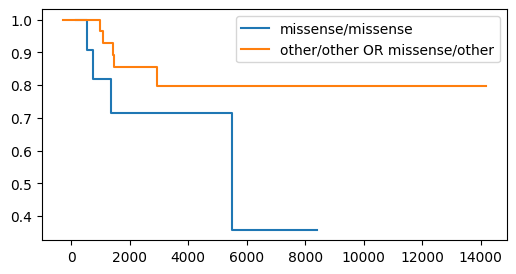

In [12]:
from gpsea.analysis.temporal.endpoint import death
term_id = "OMIM:614800"  # Short stature, optic nerve atrophy, and Pelger-Huet anomalz
endpoint = death()
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=missense_predicate,
    endpoint=endpoint,
)
print(result.pval)

_, ax = plt.subplots(figsize=(6, 3))
result.plot_kaplan_meier_curves(ax)

# Missense or frameshift variants in the https://omim.org/entry/616483

In [ ]:
r1914h = VariantPredicates.variant_key("2_15238670_15238670_C_T") # c.5741G>A	p.Arg1914His
a1921p = VariantPredicates.variant_key("2_15238650_15238650_C_G") # c.5761G>C	p.Ala1921Pro
sv = VariantPredicates.variant_key("SO:1000029_HGNC:15625_NBAS") # by inspection, these are all C term

c_term_missense = r1914h | sv



c_term_predicate =  biallelic_predicate(a_predicate=c_term_missense, 
                                   b_predicate=~c_term_missense, 
                                   a_label="missense",
                                   b_label="other",
                                   partitions=((0,),(2,1))
                                   )

## ex 35-47
#ex35 = VariantPredicates.exon(exon=35)
c_term_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=c_term_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=c_term_result)

Empty DataFrame
Columns: [(missense/missense, Count), (missense/missense, Percent), (other/other OR missense/other, Count), (other/other OR missense/other, Percent), (, p values)]
Index: []